In [1]:
"""
A simple convolutional neural network to classify mnist dataset.
Implemented with PyTorch, Python 3.6, Jupyter Notebook.
"""

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.autograd as atgd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

In [2]:
"""
loading training and testing data. 
"""

batchsize = 16

transform = transforms.Compose(
    [
    transforms.Resize((32,32)),    
    transforms.ToTensor(),
    ])

"""
download mnist dataset from internet 
"""
train_dataset = torchvision.datasets.MNIST(root = './data/mnist', 
                           train = True, 
                           transform = transform,
                           download = True) 
test_dataset = torchvision.datasets.MNIST(root = './data/mnist',
                           train = False,
                           transform = transform,
                           download = True)

"""
use dataloader to go through images and labels
"""
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)
single_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True, num_workers=1)

Trainsize = len(train_loader) * batchsize
Testsize = len(test_loader) * batchsize

print("The number of training images: ", Trainsize)
print("The number of testing images: ", Testsize)
print("Data successfully loaded!")

The number of training images:  60000
The number of testing images:  10000
Data successfully loaded!


In [3]:
"""
The definition for network structure. This is a simple network using 2 convolutional
layers, 2 max pooling layers and one fully connection layers. We use cross entropy loss 
and SGD method for the BP. 
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 10)
        
    def forward(self, x):
        x = func.relu(self.conv1(x))
        self.after_conv1 = x
        
        x = self.pool(x)
        self.after_pool1 = x
        
        x = func.relu(self.conv2(x))
        self.after_conv2 = x
        x = self.pool(x)
        
        self.after_pool2 = x
        
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        return x

net = Net()
net = net.cuda()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=10, bias=True)
)


In [4]:
"""
This function is used to compute the accuracy and loss for model(net) 
and input data (data_loader). 
"""

def compute_acc_loss(net, data_loader):
    correct = 0
    total = 0
    running_loss = 0
    for i, data in enumerate(data_loader, 0):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        
        train_loss = criterion(outputs, labels)
        running_loss += train_loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
        
    return 100 * correct / total, running_loss / (len(data_loader) * batchsize) 

In [5]:
"""
This is the main process of training. We can define the epoch_num at the beginning
of training process.
"""

epoch_num = 20
accuracy1 = []
accuracy2 = []
loss1 = []
loss2 = []

for epoch in range(epoch_num): 
    for i, data in enumerate(train_loader, 0):     
        inputs, labels = data         
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()     
        outputs = net(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

    """
    training accuracy and loss.
    save the accuracy and loss in lists to visualize the result
    """
    
    acc, loss = compute_acc_loss(net, train_loader)
    accuracy1.append(acc)
    loss1.append(loss)
    print("epoch number %d: training acc %.3f%%, training loss %.3f, " 
          % (epoch + 1, acc, loss), end = " ")
    
    acc, loss = compute_acc_loss(net, test_loader)
    accuracy2.append(acc)
    loss2.append(loss)
    print("testing acc %.3f%%, testing loss %.3f" % (acc, loss))

print("Training process end!")


epoch number 1: training acc 95.910%, training loss 0.009,  testing acc 96.350%, testing loss 0.008
epoch number 2: training acc 97.227%, training loss 0.006,  testing acc 97.660%, testing loss 0.005
epoch number 3: training acc 97.912%, training loss 0.004,  testing acc 98.060%, testing loss 0.004
epoch number 4: training acc 98.282%, training loss 0.004,  testing acc 98.270%, testing loss 0.003
epoch number 5: training acc 98.312%, training loss 0.003,  testing acc 98.410%, testing loss 0.003
epoch number 6: training acc 98.450%, training loss 0.003,  testing acc 98.660%, testing loss 0.003
epoch number 7: training acc 98.373%, training loss 0.003,  testing acc 98.470%, testing loss 0.003
epoch number 8: training acc 98.700%, training loss 0.003,  testing acc 98.720%, testing loss 0.003
epoch number 9: training acc 98.630%, training loss 0.003,  testing acc 98.490%, testing loss 0.003
epoch number 10: training acc 98.677%, training loss 0.003,  testing acc 98.680%, testing loss 0.003

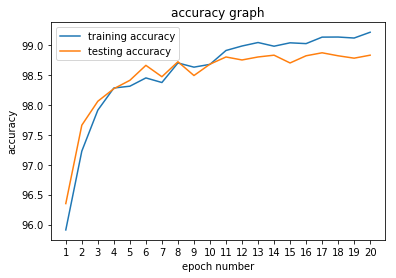

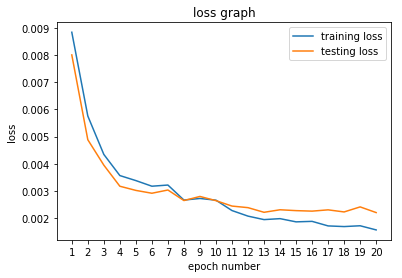

In [6]:
"""
Use plotmatlib to visualize the accuracy and loss by line chart.
"""

x = range(1,epoch_num+1)
plt.plot(x, accuracy1, label="training accuracy")
plt.plot(x, accuracy2, label="testing accuracy")
plt.xlabel("epoch number")
plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("accuracy")
plt.title("accuracy graph")
plt.legend()
plt.show()

plt.plot(x, loss1, label="training loss")
plt.plot(x, loss2, label="testing loss")
plt.xlabel("epoch number")
plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
plt.show()

number 0 test_acc: 99.388
number 1 test_acc: 99.559
number 2 test_acc: 98.353
number 3 test_acc: 98.911
number 4 test_acc: 98.880
number 5 test_acc: 98.430
number 6 test_acc: 99.165
number 7 test_acc: 97.957
number 8 test_acc: 98.665
number 9 test_acc: 98.910


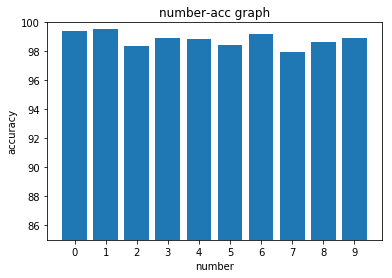

In [7]:
"""
Here we calculate the accuracy for different numbers. 
"""

correct = [0.0]*10
total = [0.0]*10
for data in single_loader:
    images, labels = data 
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total[labels] += 1
    correct[labels] += (predicted == labels).sum().item()  
    
num_acc = []
for i in range(10):
    num_acc.append(100*correct[i]  / total[i])
    print("number %d test_acc: %.3f" % (i, 100*correct[i]  / total[i]))
    
"""
draw a histogram to show the classification accuracy for different numbers. 
"""

num = range(0,10)
plt.bar(num, num_acc)

plt.xlabel("number")
plt.ylim((85,100))
plt.xticks(np.linspace(0,9,10))
plt.ylabel("accuracy")
plt.title("number-acc graph")
plt.show()

Ground Truth:  7
Model Result:  8


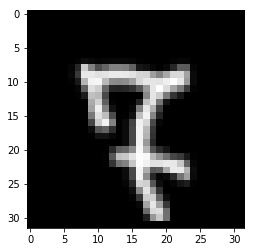

In [10]:
"""
Here we can randomly show the incorrect result.
"""

for data in single_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    
    if predicted != labels:
        plt.imshow(images.squeeze(), cmap = "gray")
        print("Ground Truth: ", labels.item())
        print("Model Result: ", predicted.item())
        break    


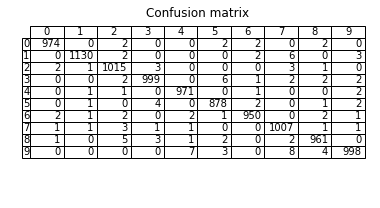

In [8]:
"""
Here we output the confusion matrix. This matrix will show how many numbers are 
classified correctly and how incorrect results are distributed. The row above is
ground truth and the columm on the left is the predicted result. 
"""

cells = [([0]*10)for i in range(10)]
for data in single_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    cells[predicted.item()][labels.item()] += 1

"""
draw the table
"""
labels_num = [i for i in range(10)]
predicted_num = [i for i in range(10)]
plt.subplot2grid((4,3), (0,0), colspan=5, rowspan=3)
plt.axis("off")
plt.table(rowLabels = predicted_num, colLabels = labels_num ,cellText = cells,loc="upper center",
         colWidths= [0.1]*10)
plt.title("Confusion matrix")
plt.show()


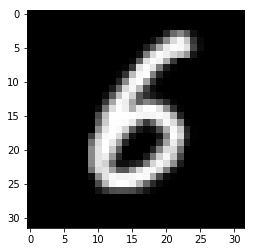

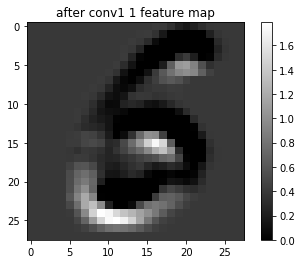

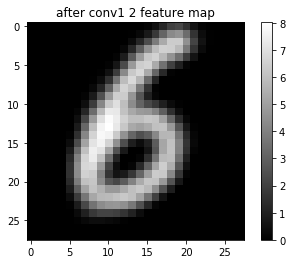

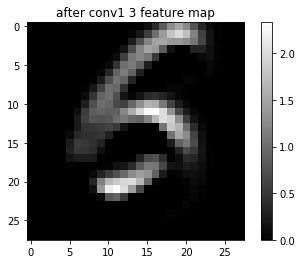

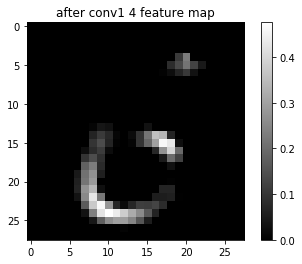

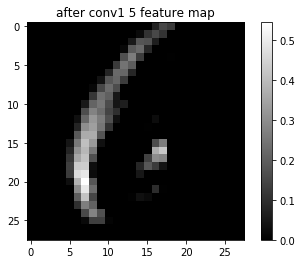

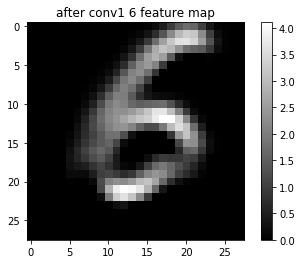

In [10]:
"""
Output the hidden layers.
Here we output only the feature maps after the first convolutional layers. 
"""

for data in single_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    
    plt.figure(0)
    plt.imshow((images.squeeze()), cmap = "gray")
    outputs = net(images)
    
    for i in range(0,6):
        plt.figure(i+1)
        plt.title("after conv1 %d feature map" % (i+1))
        plt.imshow(net.after_conv1.squeeze().detach()[i], cmap = "gray")
        plt.colorbar()
    break

In [11]:
"""
save the module in .mat file
"""

weight = dict()
weight['conv1_w'] = net._modules['conv1']._parameters['weight'].data.cpu().numpy()
weight['conv2_w'] = net._modules['conv2']._parameters['weight'].data.cpu().numpy()
weight['fc_w'] = net._modules['fc1']._parameters['weight'].data.cpu().numpy()

weight['conv1_b'] = net._modules['conv1']._parameters['bias'].data.cpu().numpy()
weight['conv2_b'] = net._modules['conv2']._parameters['bias'].data.cpu().numpy()
weight['fc_b'] = net._modules['fc1']._parameters['bias'].data.cpu().numpy()

sio.savemat('mnist_module.mat', mdict=weight)